# VAD (Voice Activity Detection) in Python-Part 1


## 1. A VAD Algorithm Returning the Probability of Speech
Originally, the VAD algorithm used to decide weather a frame is speech or not is the one proposed by Sohn et.al. [1](Sohn, Jongseo., Nam Soo Kim, and Wonyong Sung. "A Statistical Model-Based Voice Activity Detection." Signal Processing Letters IEEE. Vol. 6, No. 1, 1999.). Matlab's voiceActivityDetector implements the algorithm and returns the probability of speech given a group of sound samples which is a frame in this case. For details, refer to [Documentation > Audio Toolbox > voiceActivityDetector](https://www.mathworks.com/help/audio/ref/voiceactivitydetector-system-object.html).

This algorithm computes the probability of speech from an arbitary sample size. Therefore it is quite flexible in selecting the threshold of the probability and the frame length.

## 2. Switching from Matlab to Python
The code to make hunks was written in Matlab. It has become a phase to incorporate this functionality into the rest of code written in Python. Therefore it has become necessary to switch the VAD module from Matlab to Python.

### 2.1. Python's Pros and Cons
One of the Python's advanges is the large pool of open-source packages readily availble to use. A popular scientific ecosystem SciPy includes high quality open-source softwares such as Numpy, Matplotlib, and pandas. They are well-documented and complete in a sense that critical bugs are fixed. 

On the other hand, the disadvantage of many other open-source packages comes from the fact that they're not commercial products. Except a small number of popular packages, many open-source softwares are often imcomplete. For example, the documentation is out-dated and even inaccurate. Additionally, I have found many of them don't run or include errors that need to be fixed in order to make them work.

### 2.2. VAD Algorithms in Python
#### 2.2.1. Google Search Results
Google search results with the following keywords
  * vad python
  * python voice activity detection
  * python voice activity detection probability of speech

are summarized below.

## 3. Overview of VAD Algorithms
A web article [What are current state-of-the-art algorithms for voice activity detection?](https://www.quora.com/What-are-current-state-of-the-art-algorithms-for-voice-activity-detection), equivalently [CMUSphinx > Wiki > ASR > VAD](https://cmusphinx.github.io/wiki/asr/vad/) (both articles are identical), overviews VAD algorithms. The article is reformatted and broken links are fixed below.

### 3.1. WebRTC VAD
One of the modern fast VADs available in public is VAD from WebRTC codec. It incorporates almost all the existing features and works pretty reliable.

* ***WebRTC VAD's C++ Implementation*** is available at https://chromium.googlesource.com/external/webrtc/+/master/common_audio/vad/.
* ***Python Interface to the WebRTC VAD***
is available at https://github.com/wiseman/py-webrtcvad/.

#### 3.1.1. WebRTC VAD's C++ Implementation
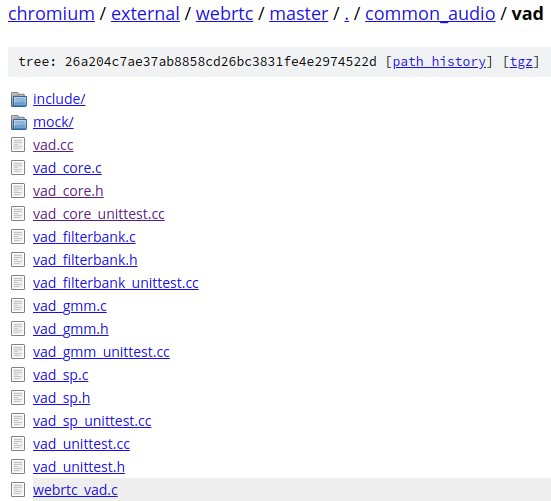


#### 3.1.2. Python Interface to the WebRTC VAD [py-webrtcvad](https://github.com/wiseman/py-webrtcvad)
This Github repository shares a Python interface to the WebRTC VAD. Given a short segment or frame from the audio file, the WebRTC VAD returns if the frame is a speech or not. It only accepts 16-bit mono PCM audio, sampled at 8000, 16000, 32000 or 48000 Hz. A frame must be either 10, 20, or 30 ms in duration.

For details, refer to the next section as WebRTC is tested.

```python
# webrtcvad.py
import pkg_resources

import _webrtcvad

__author__ = "John Wiseman jjwiseman@gmail.com"
__copyright__ = "Copyright (C) 2016 John Wiseman"
__license__ = "MIT"
__version__ = pkg_resources.get_distribution('webrtcvad').version


class Vad(object):
    def __init__(self, mode=None):
        self._vad = _webrtcvad.create()
        _webrtcvad.init(self._vad)
        if mode is not None:
            self.set_mode(mode)

    def set_mode(self, mode):
        _webrtcvad.set_mode(self._vad, mode)

    def is_speech(self, buf, sample_rate, length=None):
        length = length or int(len(buf) / 2)
        if length * 2 > len(buf):
            raise IndexError(
                'buffer has %s frames, but length argument was %s' % (
                    int(len(buf) / 2.0), length))
        return _webrtcvad.process(self._vad, sample_rate, buf, length)


def valid_rate_and_frame_length(rate, frame_length):
    return _webrtcvad.valid_rate_and_frame_length(rate, frame_length)
```

#### 3.1.3. Matlab Audio Toolbox's VAD vs. WebRTC VAD
The VAD in Matlab Audio Toolbox has two advantages over WebRTC VAD in that:
* (1) it is not limited to a frame duration.
* (2) it is more flexible in setting the threshold to determine a speech.
The reason being Matlab VAD returns the probability of speech given arbitrary frame duration.

On the contrary, WebRTC VAD's frame durations are limited to 10, 20, or 30ms. It returns True or False and does not return the probability. So it looks like I can't set my own threshold.

As a result, I can't convert the same logic in Matlab to Python. More importantly, WebRTC may be unsuitable to make sound hunks because of the frame duration limit. To create sound hunks, a smaller frame length is employed.

The disadvantage of Matlab VAD is it is not tested for severe noise while WebRTC VAD is robust to noise.

### 3.2. [Voice Activity Detector](https://github.com/marsbroshok/VAD-python)
This VAD is implemented in Python. The author didn't explain which methods or papers are referenced. I think it's the weakness ot this open-source project because I wasn't sure of the performance or robustness to noise. But this looks more flexible in that there is a room to tweak the parameters in [vad.py](https://github.com/marsbroshok/VAD-python/blob/master/vad.py).

```python
class VoiceActivityDetector():
    """ Use signal energy to detect voice activity in wav file """
    
    def __init__(self, wave_input_filename):
        self._read_wav(wave_input_filename)._convert_to_mono()
        self.sample_window = 0.02 #20 ms
        self.sample_overlap = 0.01 #10ms
        self.speech_window = 0.5 #half a second
        self.speech_energy_threshold = 0.6 #60% of energy in voice band
        self.speech_start_band = 300
        self.speech_end_band = 3000
```

In the main file [detectVoiceInWave.py](https://github.com/marsbroshok/VAD-python/blob/master/detectVoiceInWave.py), an input audio file args.inputfile is given and the output JSON file saves the detected speech intervals. 

```python
from vad import VoiceActivityDetector

v = VoiceActivityDetector(args.inputfile)
raw_detection = v.detect_speech()
speech_labels = v.convert_windows_to_readible_labels(raw_detection)
    
save_to_file(speech_labels, args.outputfile)
```

### 3.3. How VAD Works in General: FFT, Noise Removal & Classification
The main idea of most VADs is that we track and suppress noise first, then we apply some classifier to decide if the frame is speech or not and then we might want to apply some hangover to select significant speech regions and ignore small random variations in decision. Few core ideas used are:
* VAD operates in spectral instead of time domain, noise tracking is performed in mel bands.
* Statistical-based noise removal method is applied in order to separate signal from stationary noise:
  * [A Statistical Model-Based Voice Activity Detection](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.34.550) ([pdf](https://www.researchgate.net/publication/3342424_A_statistical_model_based_voice_activity_detector/link/00b7d52831dee3ada3000000/download))
  * [Noise Spectrum Estimation in Adverse Environments: Improved Minima](https://ieeexplore.ieee.org/document/1223596) ([pdf](https://pdfs.semanticscholar.org/06fe/ef1135e2e6a0e18e3654155e8a671ada043e.pdf))


### 3.4. More on Modern VAD Technologies
The current state-of-the art is pretty ad-hoc, a lot of algorithms are applied together in order to get a good performance and most of them require carefully hand-crafted parameters in order to operate reliably in noise. Most of the VAD methods deal with stationary or almost-stationary noise and there is a great variety of tweaks you can apply here. For example you can replace simple Wiener noise suppression filter with IMCRA one and get a new noise suppression algorithm and, consequently, new VAD algorithm. Same way, you can replace the classifier or add a new features to it and it will give you a new algorithm. And every new parameter in the algorithms will need tuning, in particular tuning of the computational expenses.

GMM and other machine-trained classifiers are used for several features like pitch, signal levels and so on. Recent research includes recurrent neural networks. For example, [Neural Networks For Voice Activity Detection](https://ieeexplore.ieee.org/document/6639096) ([pdf](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/41186.pdf))

This ends into fusion of the various systems. For example, [Voice Activity Detection system](https://github.com/mvansegbroeck/vad), developed as part of the RATS (Robust Automated Transcription of Speech) program of DARPA, is based on Deep Neural Networks (DNN) and feature fusion (Gammatone, Gabor, Long-term Spectral Variability and voicing).

### 3.5. Limitations: Overlapped Audio Signals
The major issue with VAD is that speech signal is considered alone and the methods for arbitrary audio signal recognition are in a pretty initial stage. So you can’t distinguish speech from other sounds because you don’t know what other sounds are. Also, the theory of separation of overlapped signals is also in a very initial stage. So most of the modern VADs operate on stationary noise only and can not deal with complex noises and overlapped speech. Things like bird singing in the background can make things pretty complex.

(EOF)